In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import datetime as dt
from pandas.plotting import table
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns

In [39]:
data=pd.read_csv('feb-20-us-flight-delay.csv')
data=data.drop(columns=['Unnamed: 9'])
data.head(2)

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,DEST,DEP_TIME,DEP_DEL15,DISTANCE
0,2,1,6,MQ,CLT,LYH,1430.0,0.0,175.0
1,2,8,6,MQ,CLT,LYH,1442.0,0.0,175.0


In [40]:
def plot_hist(variable):
    plt.figure(figsize =(9,3))
    plt.hist(data[variable], bins =50)
    plt.xlabel(variable)
    plt.ylabel("Frequency")
    plt.title("{} distribution with hist".format(variable))
    plt.show()

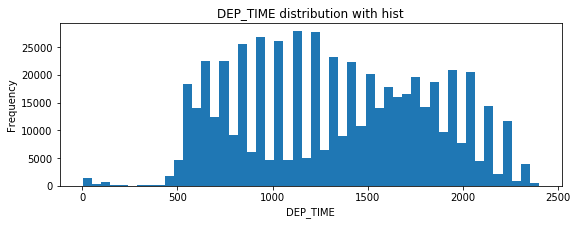

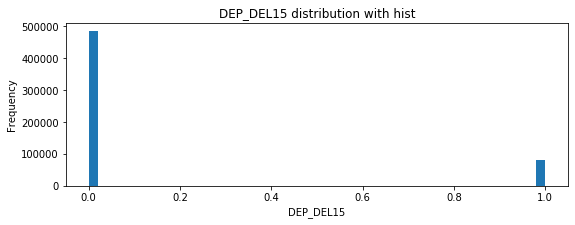

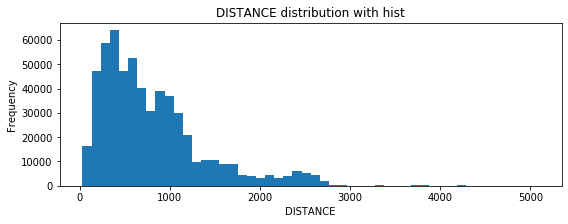

In [41]:
numericVar = ["DEP_TIME", "DEP_DEL15", "DISTANCE"]
for n in numericVar:
    plot_hist(n)


In [42]:
def bar_plot(variable):
    #get feature
    var = data[variable]
    #count number of categorical variable(value/sample)
    varValue = var.value_counts()
   
    #visualize
    plt.figure(figsize = (9,3))
    plt.bar(varValue.index, varValue)
    plt.xticks(varValue.index, varValue.index.values)
    plt.ylabel("Frequency")
    plt.title(variable)
    plt.show()
    print("{}: \n {}".format(variable, varValue))

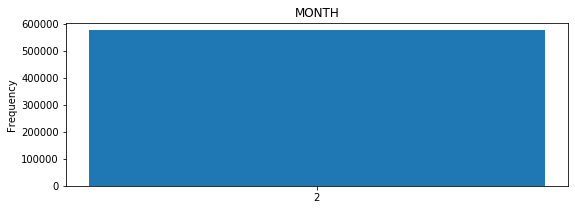

MONTH: 
 2    574268
Name: MONTH, dtype: int64


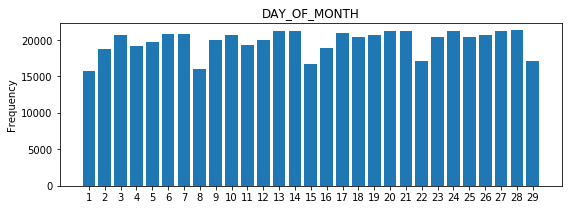

DAY_OF_MONTH: 
 28    21309
21    21293
27    21286
14    21270
20    21270
24    21247
13    21185
17    20989
7     20866
6     20826
10    20709
3     20708
26    20668
19    20661
18    20483
23    20436
25    20418
9     20007
12    19951
5     19775
11    19259
4     19225
16    18902
2     18805
22    17111
29    17103
15    16678
8     16048
1     15780
Name: DAY_OF_MONTH, dtype: int64


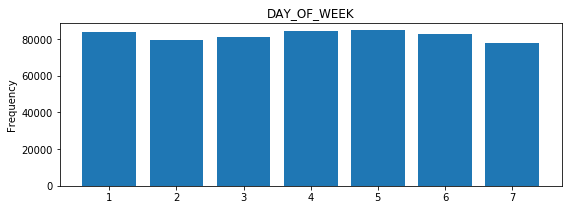

DAY_OF_WEEK: 
 5    84738
4    84567
1    83653
6    82720
3    81055
2    79385
7    78150
Name: DAY_OF_WEEK, dtype: int64


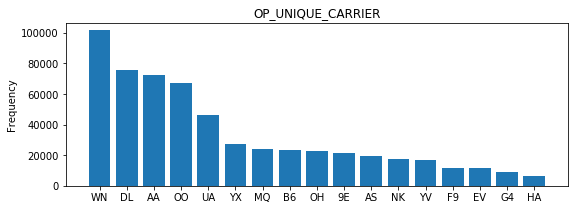

OP_UNIQUE_CARRIER: 
 WN    101581
DL     75446
AA     72402
OO     67056
UA     46244
YX     27560
MQ     24193
B6     23527
OH     22902
9E     21623
AS     19515
NK     17364
YV     16679
F9     11549
EV     11404
G4      8714
HA      6509
Name: OP_UNIQUE_CARRIER, dtype: int64


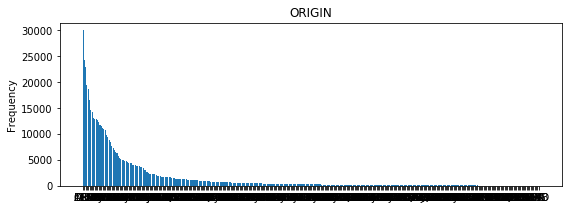

ORIGIN: 
 ATL    29964
ORD    24346
DFW    22992
DEN    19478
CLT    18765
       ...  
HGR       10
ADK        9
PPG        8
OWB        8
OGD        8
Name: ORIGIN, Length: 350, dtype: int64


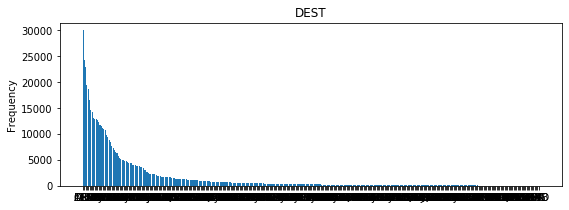

DEST: 
 ATL    29968
ORD    24358
DFW    22995
DEN    19473
CLT    18766
       ...  
HGR       10
ADK        9
PPG        8
OWB        8
OGD        8
Name: DEST, Length: 350, dtype: int64


In [43]:
category1 = ["MONTH","DAY_OF_MONTH","DAY_OF_WEEK","OP_UNIQUE_CARRIER","ORIGIN","DEST"]
for c in category1:
    bar_plot(c)

In [44]:
data = data.rename(columns={'DEP_DEL15':'target'})
data.columns

Index(['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER', 'ORIGIN',
       'DEST', 'DEP_TIME', 'target', 'DISTANCE'],
      dtype='object')

In [45]:
print(f"Average distance if there is a delay {data[data['target'] == 1]['DISTANCE'].values.mean()} miles")
print(f"Average distance if there is no delay {data[data['target'] == 0]['DISTANCE'].values.mean()} miles")

Average distance if there is a delay 786.1071280815751 miles
Average distance if there is no delay 799.7913309452206 miles


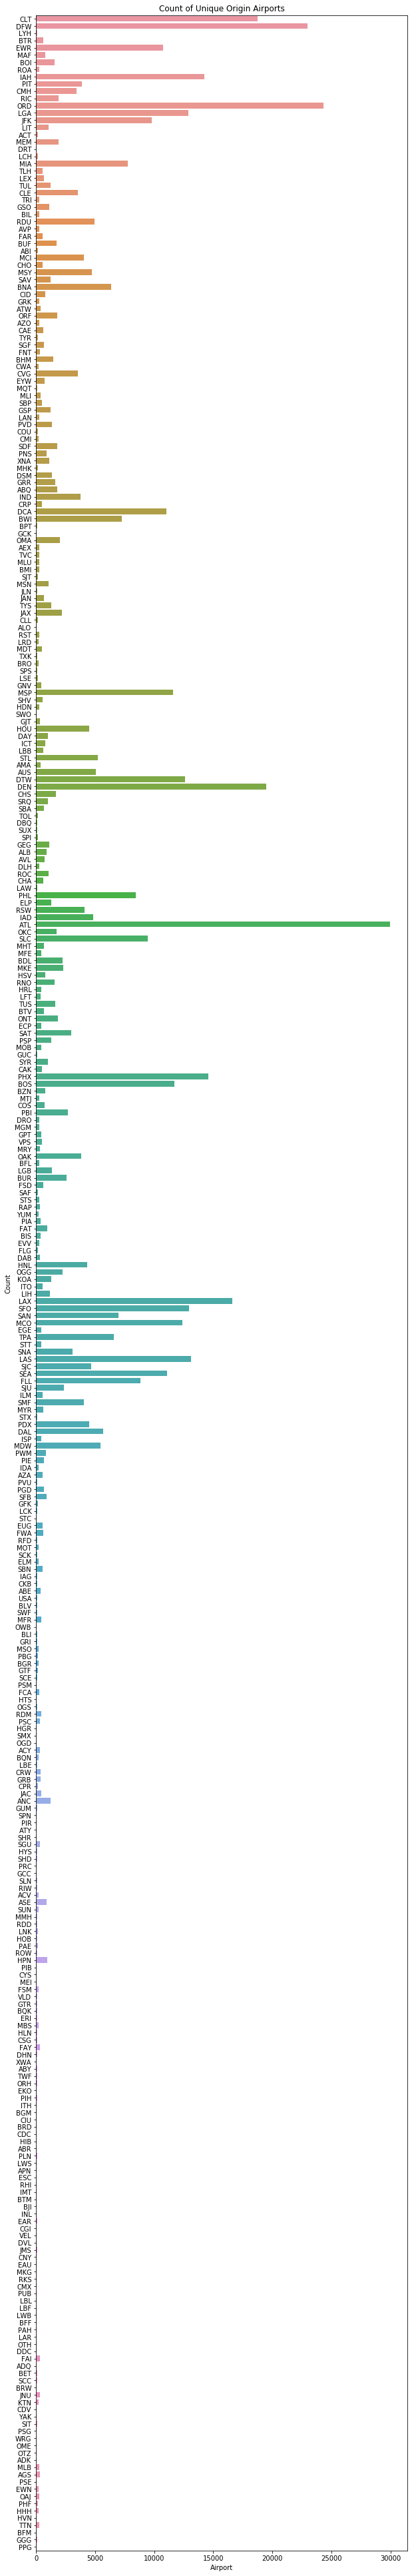

In [46]:
plt.figure(figsize=(10,70))
sns.countplot(y=data['ORIGIN'], data=data, orient="h")
plt.xlabel("Airport")
plt.ylabel("Count")
plt.title("Count of Unique Origin Airports")
plt.show()

In [47]:
data.isnull().sum()

MONTH                   0
DAY_OF_MONTH            0
DAY_OF_WEEK             0
OP_UNIQUE_CARRIER       0
ORIGIN                  0
DEST                    0
DEP_TIME             4938
target               4951
DISTANCE                0
dtype: int64

In [48]:
# Split the data into positive and negative
positive_rows = data.target == 1.0
data_pos = data.loc[positive_rows]
data_neg = data.loc[~positive_rows]

# Merge the balanced data
data = pd.concat([data_pos, data_neg.sample(n = len(data_pos))], axis = 0)

# Shuffle the order of data
data = data.sample(n = len(data)).reset_index(drop = True)

In [49]:
data = data.dropna(axis=0)

In [50]:
data['target'] = data['target'].astype(int)

## Data Modelling 

In [51]:
def label_encoding(categories):
    """
    To perform mapping of categorical features
    """
    categories = list(set(list(categories.values)))
    mapping = {}
    for idx in range(len(categories)):
        mapping[categories[idx]] = idx
    return mapping

In [52]:
data['OP_UNIQUE_CARRIER'] = data['OP_UNIQUE_CARRIER'].map(label_encoding(data['OP_UNIQUE_CARRIER']))
data['ORIGIN'] = data['ORIGIN'].map(label_encoding(data['ORIGIN']))
data['DEST'] = data['DEST'].map(label_encoding(data['DEST']))
data.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,DEST,DEP_TIME,target,DISTANCE
0,2,2,7,0,185,217,2122.0,1,1674.0
1,2,14,5,5,54,306,2210.0,1,909.0
2,2,17,1,6,89,78,936.0,0,296.0
3,2,27,4,5,209,223,1109.0,0,651.0
4,2,1,6,13,141,311,1049.0,0,100.0


In [53]:
from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

In [54]:
X = data[['DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST', 'DEP_TIME', 'DISTANCE']].values
y = data[['target']].values

In [55]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.23, random_state=201)

# Splitting Train-set and Validation-set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=50)

In [56]:
def get_accuracy(y_true, y_preds):
    # Getting score of confusion matrix
    true_negative, false_positive, false_negative, true_positive = confusion_matrix(y_true, y_preds).ravel()
    # Calculating accuracy
    accuracy = (true_positive + true_negative)/(true_negative + false_positive + false_negative + true_positive)
    return accuracy

In [57]:
catboost = CatBoostClassifier(random_state=0)
catboost.fit(X_train, y_train, verbose=False)

In [58]:
lr = LogisticRegression(random_state=0).fit(X_train, y_train)

In [59]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [60]:
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [61]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

In [62]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [63]:
models = [lr, catboost, gnb, rf, knn, xgb]
acc = []
for model in models:
    preds_val = model.predict(X_val)
    accuracy = get_accuracy(y_val, preds_val)
    acc.append(accuracy)

In [64]:
model_name = ['Logistic Regression', 'Catboost', 'Naive Bayes', 'Random Forest', 'KNN', 'XGBoost']
accuracy = dict(zip(model_name, acc))

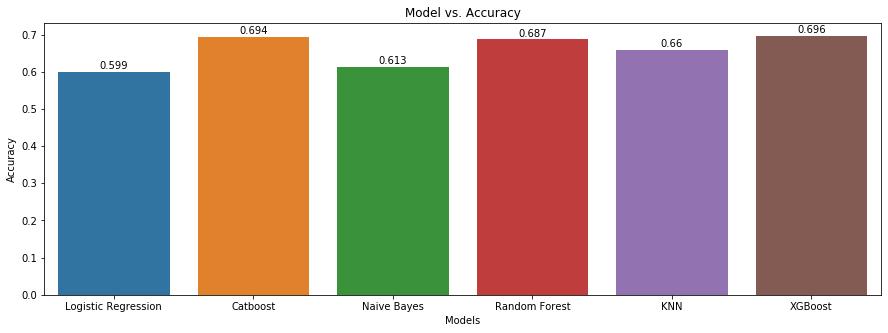

In [65]:
plt.figure(figsize=(15,5))
ax = sns.barplot(x = list(accuracy.keys()), y = list(accuracy.values()))
for p, value in zip(ax.patches, list(accuracy.values())):
    _x = p.get_x() + p.get_width() / 2
    _y = p.get_y() + p.get_height() + 0.008
    ax.text(_x, _y, round(value, 3), ha="center") 
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model vs. Accuracy")
plt.show()

In [67]:
leaf_size = list(range(1,5))
n_neighbors = list(range(1,3))
p=[1,2]

hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

knn_2 = KNeighborsClassifier()

clf = GridSearchCV(knn_2, hyperparameters, cv=2)

best_model = clf.fit(X_train,y_train)

print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

Best leaf_size: 2
Best p: 1
Best n_neighbors: 1


In [68]:
knn_best = KNeighborsClassifier(leaf_size=3, p=1, n_neighbors=1)
knn_best.fit(X_train, y_train)
test_preds_1 = knn_best.predict(X_test)

In [69]:
get_accuracy(y_test, test_preds_1)

0.7502791216970599